In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%matplotlib inline

Feature Engineering


In [2]:
canterbury_data = pd.read_csv('processed_canterbury_housing_features.csv')
canterbury_data['Date'] = pd.to_datetime(canterbury_data['Date'])

canterbury_data['Month'] = canterbury_data['Date'].dt.month
canterbury_data['Year'] = canterbury_data['Date'].dt.year
canterbury_data['DayOfWeek'] = canterbury_data['Date'].dt.dayofweek

canterbury_data['Price_Lag_1'] = canterbury_data['Price'].shift(1)
canterbury_data['Price_Lag_7'] = canterbury_data['Price'].shift(7)

canterbury_data['Price_Rolling_Mean_7'] = canterbury_data['Price'].rolling(window=7).mean()
canterbury_data['Price_Rolling_Mean_30'] = canterbury_data['Price'].rolling(window=30).mean()

canterbury_data = canterbury_data.dropna()

print(canterbury_data.head())
print(canterbury_data.info())

         Date   Price      Region  Month  Season  Spring  Summer  Winter  \
29 2018-07-23  503748  Canterbury      7  Winter   False   False    True   
30 2018-07-30  503942  Canterbury      7  Winter   False   False    True   
31 2018-08-06  503627  Canterbury      8  Winter   False   False    True   
32 2018-08-13  503731  Canterbury      8  Winter   False   False    True   
33 2018-08-20  503763  Canterbury      8  Winter   False   False    True   

    Year  Months_Since_2000  DayOfWeek  Price_Lag_1  Price_Lag_7  \
29  2018                223          0     503651.0     503466.0   
30  2018                223          0     503748.0     503344.0   
31  2018                224          0     503942.0     503770.0   
32  2018                224          0     503627.0     503903.0   
33  2018                224          0     503731.0     503330.0   

    Price_Rolling_Mean_7  Price_Rolling_Mean_30  
29         503614.285714          502326.166667  
30         503699.714286          

In [3]:
features = ['Year', 'Month', 'DayOfWeek', 'Spring', 'Summer', 'Winter', 
            'Months_Since_2000', 'Price_Lag_1', 'Price_Lag_7', 
            'Price_Rolling_Mean_7', 'Price_Rolling_Mean_30']
X = canterbury_data[features]
y = canterbury_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features used:", features)
print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)

Features used: ['Year', 'Month', 'DayOfWeek', 'Spring', 'Summer', 'Winter', 'Months_Since_2000', 'Price_Lag_1', 'Price_Lag_7', 'Price_Rolling_Mean_7', 'Price_Rolling_Mean_30']
Shape of training data: (212, 11)
Shape of testing data: (53, 11)


CG model prediction

In [4]:
# Cell 4: Train model and make predictions
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 3950815.3265772406
Root Mean Squared Error: 1987.665798512728
R-squared Score: 0.9996741414070129


In [5]:
# Cell 5: Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-validation RMSE scores: {cv_rmse}")
print(f"Average cross-validation RMSE: {cv_rmse.mean()}")

Cross-validation RMSE scores: [3431.00123032 2530.03512219 4379.11433357 2759.80417134 4529.14549754]
Average cross-validation RMSE: 3525.8200709909534


Feature Imprtance

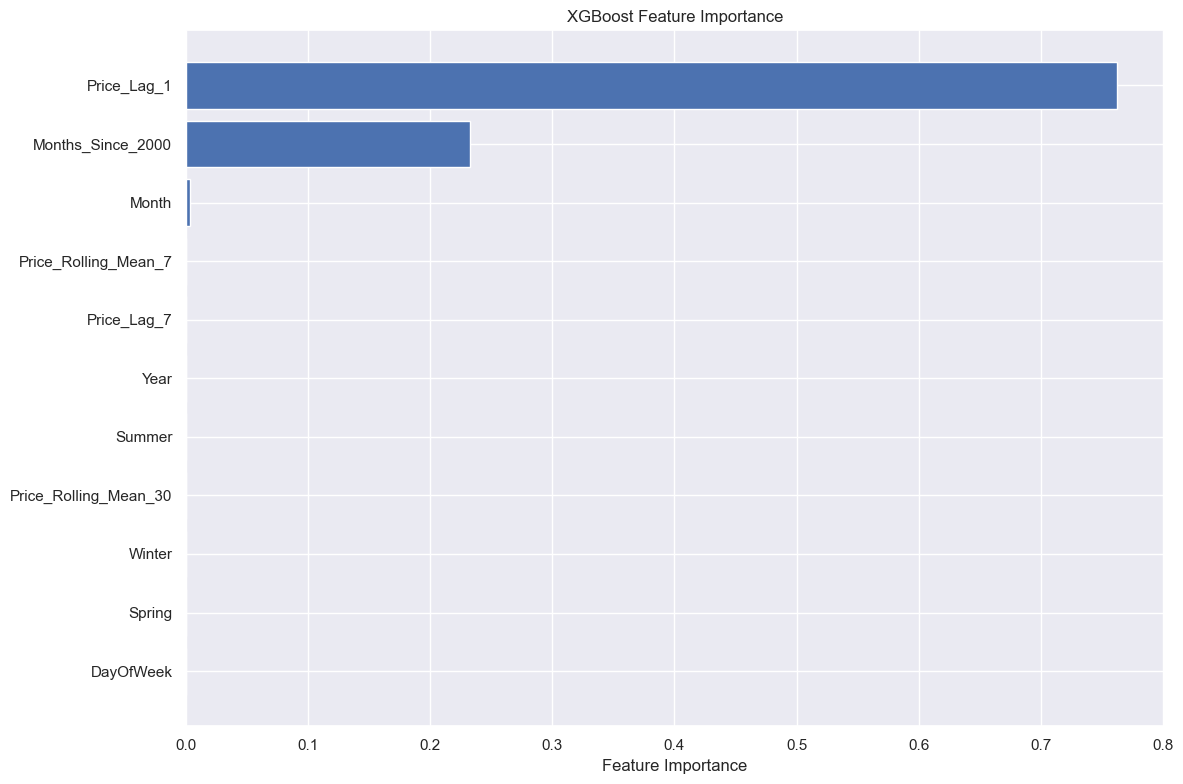

In [6]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(features)[sorted_idx])
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

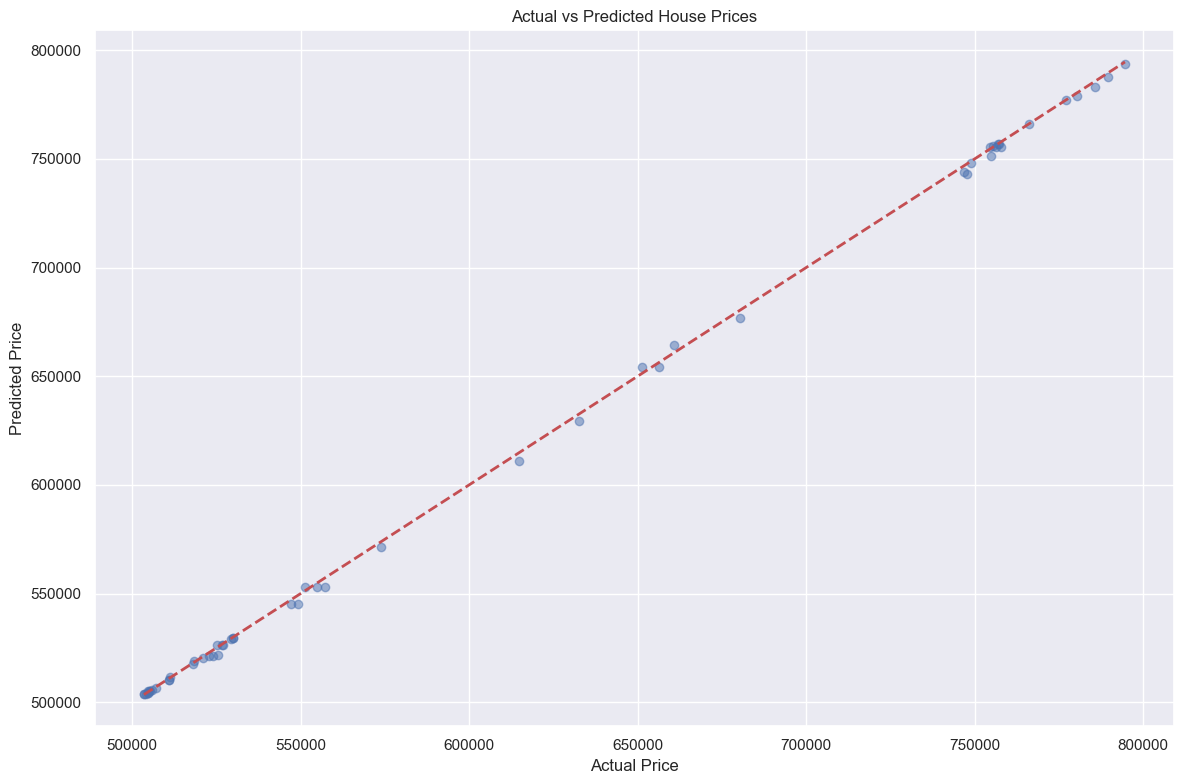

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices')
plt.tight_layout()
plt.show()

In [8]:
last_date = canterbury_data['Date'].max()
future_dates = pd.date_range(start='2025-01-01', end='2025-12-31', freq='Q')

last_known_price = canterbury_data['Price'].iloc[-1]
last_known_lag_7 = canterbury_data['Price_Lag_7'].iloc[-1]
last_known_rolling_mean_7 = canterbury_data['Price_Rolling_Mean_7'].iloc[-1]
last_known_rolling_mean_30 = canterbury_data['Price_Rolling_Mean_30'].iloc[-1]

future_predictions = []

for future_date in future_dates:
    future_features = pd.DataFrame({
        'Year': [future_date.year],
        'Month': [future_date.month],
        'DayOfWeek': [future_date.dayofweek],
        'Spring': [1 if future_date.month in [9, 10, 11] else 0],
        'Summer': [1 if future_date.month in [12, 1, 2] else 0],
        'Winter': [1 if future_date.month in [6, 7, 8] else 0],
        'Months_Since_2000': [(future_date.year - 2000) * 12 + future_date.month],
        'Price_Lag_1': [last_known_price],
        'Price_Lag_7': [last_known_lag_7],
        'Price_Rolling_Mean_7': [last_known_rolling_mean_7],
        'Price_Rolling_Mean_30': [last_known_rolling_mean_30]
    })
    
    future_features_scaled = scaler.transform(future_features)
    predicted_price = model.predict(future_features_scaled)[0]
    future_predictions.append(predicted_price)
    
    last_known_price = predicted_price

future_pred_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions
})

print(future_pred_df)

        Date  Predicted_Price
0 2025-03-31      756887.3750
1 2025-06-30      756795.9375
2 2025-09-30      756158.5000
3 2025-12-31      756316.3750


C:\Users\arawa\AppData\Local\Temp\ipykernel_27980\50660570.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start='2025-01-01', end='2025-12-31', freq='Q')


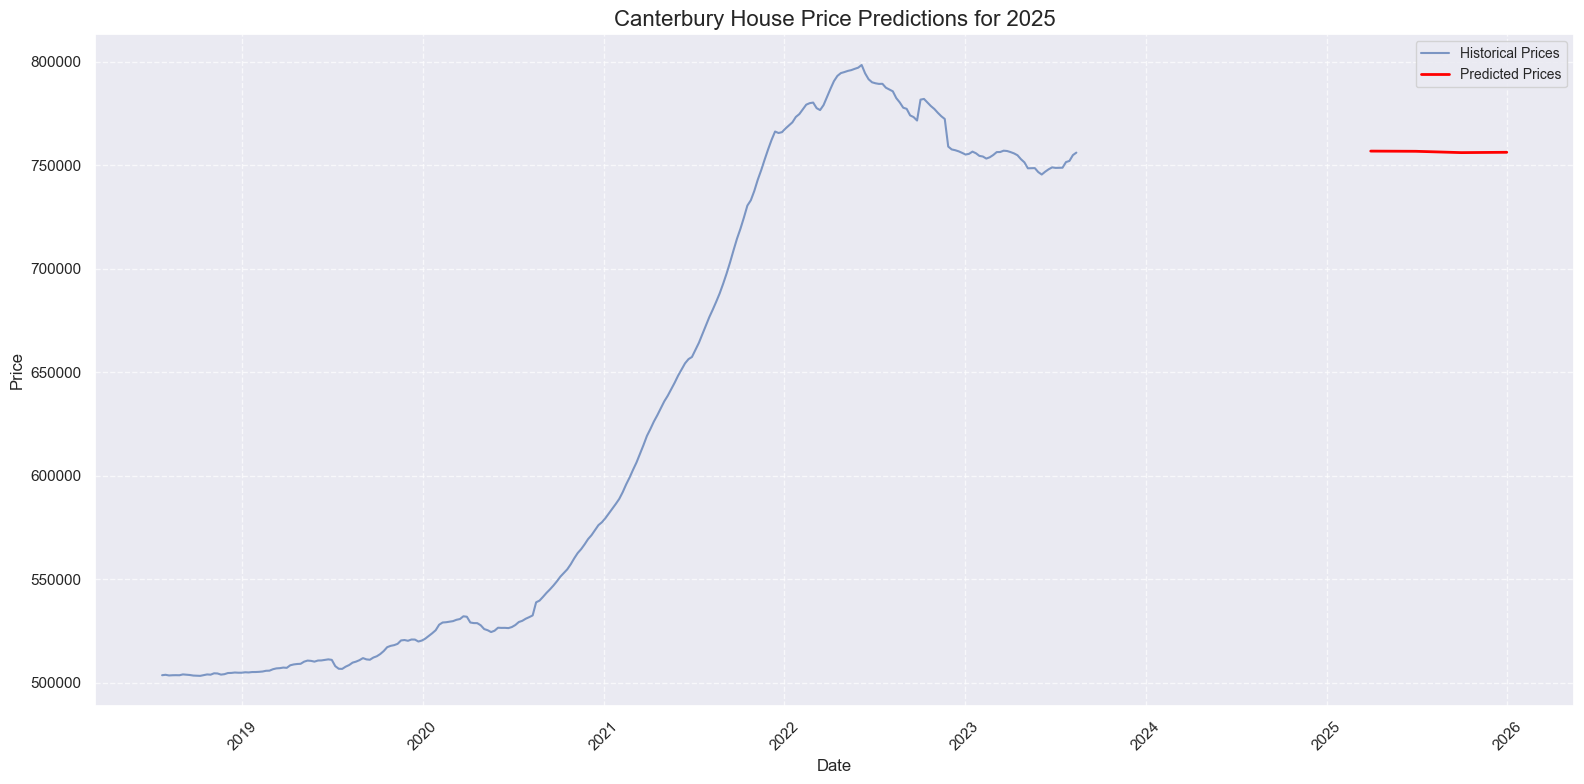

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(canterbury_data['Date'], canterbury_data['Price'], label='Historical Prices', alpha=0.7)
plt.plot(future_pred_df['Date'], future_pred_df['Predicted_Price'], label='Predicted Prices', color='red', linewidth=2)
plt.title('Canterbury House Price Predictions for 2025', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

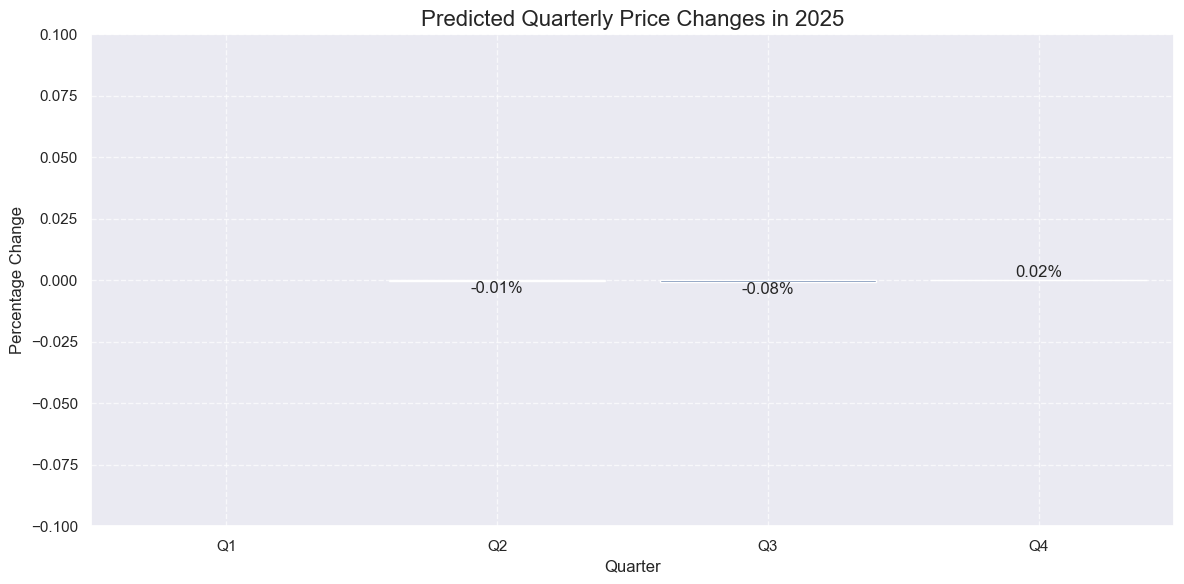

In [10]:
future_pred_df['Quarter'] = future_pred_df['Date'].dt.quarter
future_pred_df['Quarterly_Change'] = future_pred_df['Predicted_Price'].pct_change()

plt.figure(figsize=(12, 6))
sns.barplot(x='Quarter', y='Quarterly_Change', data=future_pred_df)
plt.title('Predicted Quarterly Price Changes in 2025', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Percentage Change', fontsize=12)
plt.ylim(-0.1, 0.1)  
plt.xticks(range(4), ['Q1', 'Q2', 'Q3', 'Q4'])
for i, v in enumerate(future_pred_df['Quarterly_Change']):
    if not np.isnan(v):
        plt.text(i, v, f'{v:.2%}', ha='center', va='bottom' if v > 0 else 'top')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


In [12]:
best_model = xgb.XGBRegressor(**grid_search.best_params_, random_state=42)

best_model.fit(X_train_scaled, y_train)

y_pred_best = best_model.predict(X_test_scaled)

mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model - Mean Squared Error: {mse_best}")
print(f"Best Model - Root Mean Squared Error: {rmse_best}")
print(f"Best Model - R-squared Score: {r2_best}")

Best Model - Mean Squared Error: 3732349.794424381
Best Model - Root Mean Squared Error: 1931.929034520777
Best Model - R-squared Score: 0.9996922016143799


In [13]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

catboost_model = CatBoostRegressor(random_state=42, verbose=0)
catboost_model.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_model.predict(X_test_scaled)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
r2_catboost = r2_score(y_test, y_pred_catboost)

print(f"LightGBM - RMSE: {rmse_lgbm}, R-squared: {r2_lgbm}")
print(f"CatBoost - RMSE: {rmse_catboost}, R-squared: {r2_catboost}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 10
[LightGBM] [Info] Start training from score 634590.679245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [14]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print("Time Series Cross-Validation RMSE scores:", cv_rmse)
print("Average RMSE:", cv_rmse.mean())

Time Series Cross-Validation RMSE scores: [8360.62662314 5421.10849591 4333.65270366 4176.87638316 2953.20194253]
Average RMSE: 5049.093229679971


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

canterbury_data = pd.read_csv('processed_canterbury_housing_features.csv')
canterbury_data['Date'] = pd.to_datetime(canterbury_data['Date'])

print("Initial shape:", canterbury_data.shape)

def create_features(df):
    df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)
    
    for lag in [1, 7]:
        df[f'Price_Lag_{lag}'] = df['Price'].shift(lag)
    
    for window in [7, 30]:
        df[f'Price_Rolling_Mean_{window}'] = df['Price'].rolling(window=window).mean()
        df[f'Price_Rolling_Std_{window}'] = df['Price'].rolling(window=window).std()
    
    for period in [7, 30]:
        df[f'Price_Momentum_{period}'] = df['Price'].pct_change(periods=period)
    
    df['Price_Lag_1_x_Month'] = df['Price_Lag_1'] * df['Month']
    df['Rolling_Mean_7_x_Year'] = df['Price_Rolling_Mean_7'] * df['Year']
    
    return df

canterbury_data = create_features(canterbury_data)

print("Shape after feature engineering:", canterbury_data.shape)

canterbury_data = canterbury_data.dropna()

print("Shape after dropping NaN values:", canterbury_data.shape)

features = ['Year', 'Month', 'Month_sin', 'Month_cos', 'Spring', 'Summer', 'Winter', 
            'Months_Since_2000', 'Price_Lag_1', 'Price_Lag_7',
            'Price_Rolling_Mean_7', 'Price_Rolling_Mean_30',
            'Price_Rolling_Std_7', 'Price_Rolling_Std_30',
            'Price_Momentum_7', 'Price_Momentum_30',
            'Price_Lag_1_x_Month', 'Rolling_Mean_7_x_Year']

existing_features = [f for f in features if f in canterbury_data.columns]
missing_features = set(features) - set(existing_features)
if missing_features:
    print(f"The following features are missing from the dataset: {missing_features}")
    features = existing_features

X = canterbury_data[features]
y = canterbury_data['Price']

print("Final shape of X:", X.shape)
print("Final shape of y:", y.shape)




Initial shape: (294, 10)
Shape after feature engineering: (294, 22)
Shape after dropping NaN values: (264, 22)
Final shape of X: (264, 18)
Final shape of y: (264,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

catboost_model = CatBoostRegressor(random_state=42, verbose=0)
catboost_model.fit(X_train_scaled, y_train)

y_pred_catboost = catboost_model.predict(X_test_scaled)

mse_catboost = mean_squared_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mse_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print(f"CatBoost - RMSE: {rmse_catboost}")
print(f"CatBoost - R-squared: {r2_catboost}")

feature_importance = catboost_model.feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)


CatBoost - RMSE: 3119.3763919380117
CatBoost - R-squared: 0.9992790546415157


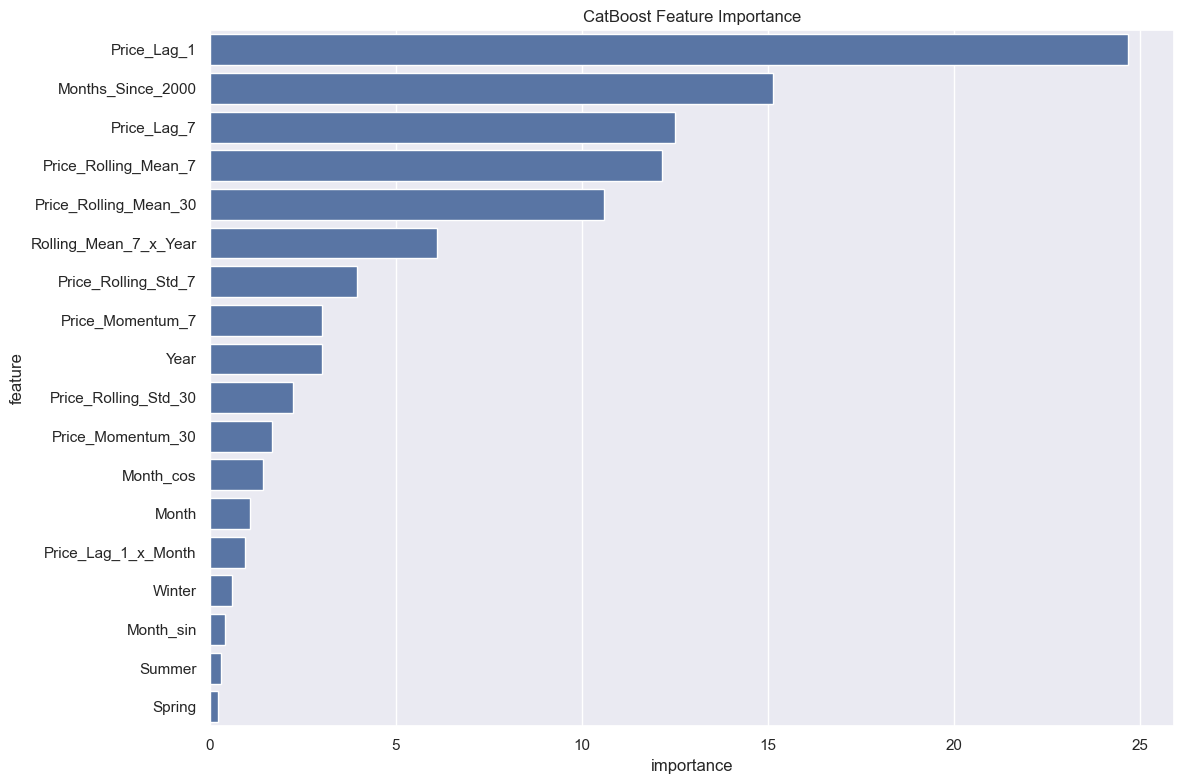

In [17]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()



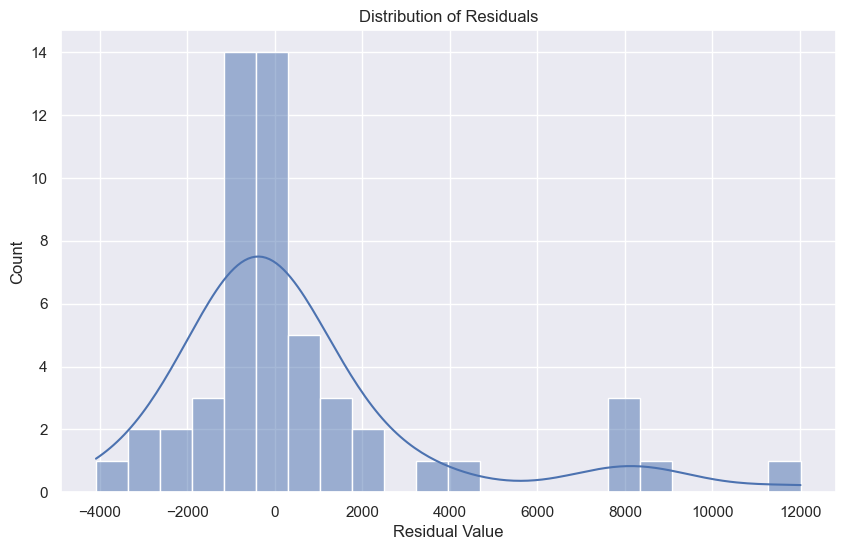

In [18]:
residuals = y_test - y_pred_catboost
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.show()



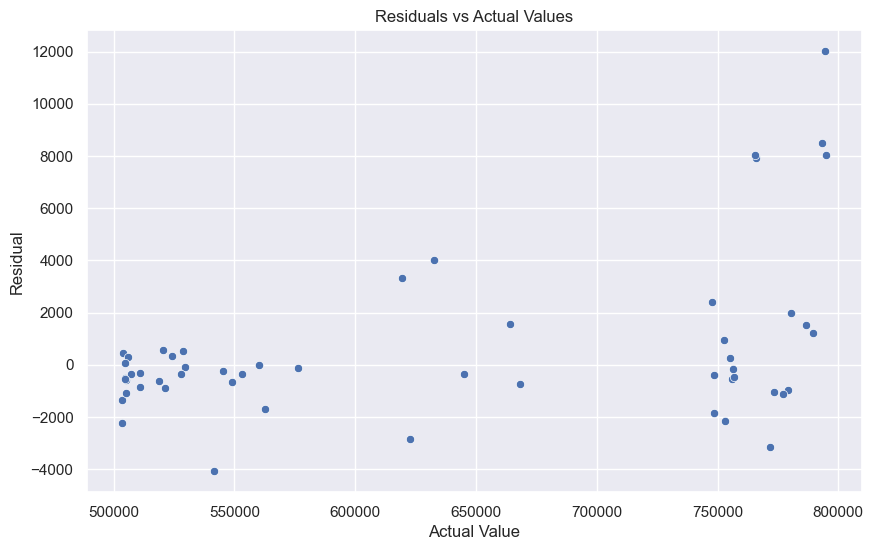

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Value')
plt.ylabel('Residual')
plt.show()